In [12]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap # plot on map projections

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [13]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [14]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [15]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

The function below calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average over the standard time period.

In [16]:
def get_gyre_psi(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    cntrl_tx_trans = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',use_cache=True,
                                        n=n_files,time_units=time_units, offset=offset)\
                                        .sel(time=slice(tstart,tend))\
                                        .mean('time')
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts

    # write to disk
#     gyre_psi.to_netcdf(NOSYNC + expt + '_gyre_psi_' + yearrange +'.nc')
    
    return gyre_psi

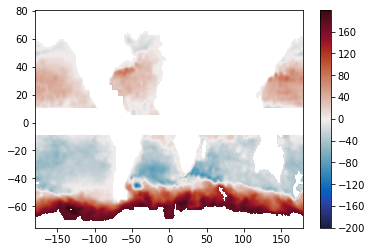

In [17]:
data=loadmat('/g/data3/hh5/tmp/cosima/observations/original/psi_barotropic.mat')
lon = data['lon_p'][0,:]
lat = data['lat_p'][0,:]
psi = data['psi']/1e6 # in Sv
plt.contourf(lon,lat,psi,levels=np.arange(-200,200),cmap = cm.cm.balance)
plt.colorbar()

In [18]:
# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
# cmp = plt.get_cmap('gist_ncar_r')  # confusing with the most common form of colourblindness (deuteranomaly)
cmp = plt.get_cmap('nipy_spectral')

In [19]:
%%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',use_cache=True,
                               n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',use_cache=True,
                                 n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_1deg = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_1deg.load()

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean_month.nc_sea_level_-12_days-since-1718-01-01_-87658_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean_month.nc_sea_levelsq_-12_days-since-1718-01-01_-87658_False.pkl
CPU times: user 5.16 s, sys: 1.38 s, total: 6.54 s
Wall time: 4.69 s


In [20]:
def gulfstream_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)

    map = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=64.9,\
            llcrnrlon=-95,urcrnrlon=-5,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

1deg_jra55v13_iaf_spinup1_B1
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean_month.nc_tx_trans_int_z_-12_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
025deg_jra55v13_iaf_gmredi6
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Saving cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_ocean_month.nc_tx_trans_int_z_-34_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: RuntimeWarning: invalid value encountered in less_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3657: RuntimeWarning: invalid value encountered in greater
  xx = ma.masked_where(x > 1.e20, x)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3658: RuntimeWarning: invalid value encountered in greater
  yy = ma.masked_where(y > 1.e20, y)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap

01deg_jra55v13_iaf
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Saving cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_tx_trans_int_z_None_days-since-0001-01-01_None_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: RuntimeWarning: invalid value encountered in less_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3657: RuntimeWarning: invalid value encountered in greater
  xx = ma.masked_where(x > 1.e20, x)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3658: RuntimeWarning: invalid value encountered in greater
  yy = ma.masked_where(y > 1.e20, y)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/mpl_toolkits/basemap

CPU times: user 13min 35s, sys: 4min 47s, total: 18min 23s
Wall time: 18min 3s


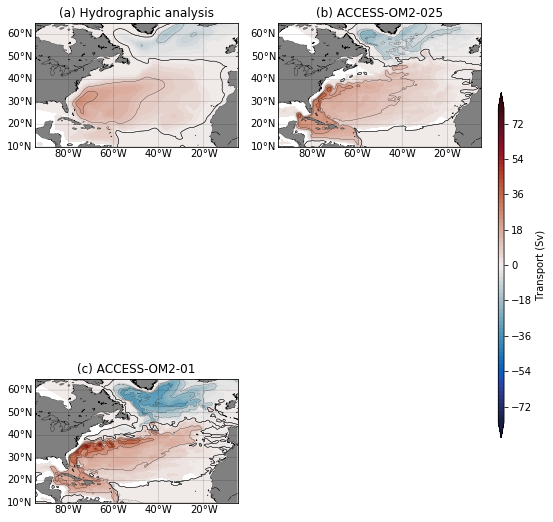

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [22]:
%%time
plt.figure(1,figsize(8,12))
plt.figure(2,figsize(12,6))
plt.figure(3,figsize(12,6))
plt.figure(4,figsize(12,8))
plt.figure(5,figsize(12,6))

plot_labels=['(a) ','(b) ','(c) ']

for i, ekey in enumerate(exptdata.exptdict.keys()):
#for i, ekey in enumerate(['1deg']):
    expt = exptdata.exptdict[ekey]['expt']
    print(expt)
    
    gyre_psi = get_gyre_psi(ekey)
    geolon_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolon_t',n=1)
    geolat_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolat_t',n=1)
    
    label=plot_labels[i]
    
    plt.figure(1)
    plt.subplot(2,2,i+1)
    p4 = gulfstream_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
plt.figure(1)
subplot(221)
plt.title('(a) Hydrographic analysis')
ax3 = plt.axes([0.93,0.3,0.01,0.4])
cb = plt.colorbar(p4,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('gulfstream_barotropic_streamfunctions')

In [27]:
##old fashioned way
NYFCntrlDir = '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1_lastcycle/output*/ocean'

Ocean_File = os.path.join(NYFCntrlDir,'ocean.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(cntrl.tx_trans.shape)

#store annual mean gmoc (instead of seasonal)
cntrl_psi=np.zeros((cntrl.tx_trans.shape[0],cntrl.tx_trans.shape[2],cntrl.tx_trans.shape[3]))
print(cntrl_psi.shape)

print(cntrl.yt_ocean)

for t in range(cntrl.tx_trans.shape[0]):
    print(t)
    cntrl_psi[t,:,:]=cntrl.tx_trans[t,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()

    #cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    #gyre_psi = -cntrl_psi+cntrl_dp_ts


of=os.path.join('/g/data1a/v45/pas561/access-om2_amoc/','om2_1_bsf.npy')
a=np.save(of,cntrl_psi)

/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1_lastcycle/output*/ocean/ocean.nc
(60, 50, 300, 360)
(60, 300, 360)
<xarray.DataArray 'yt_ocean' (yt_ocean: 300)>
array([-77.876623, -77.629713, -77.381707, ...,  88.872933,  89.324006,
        89.774476])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [ ]:
##old fashioned way
NYFCntrlDir = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output*/ocean'

Ocean_File = os.path.join(NYFCntrlDir,'ocean.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(cntrl.tx_trans.shape)

#store annual mean gmoc (instead of seasonal)
cntrl_psi=np.zeros((60,cntrl.tx_trans.shape[2],cntrl.tx_trans.shape[3]))
print(cntrl_psi.shape)

print(cntrl.yt_ocean)

for t in range(60):
    print(t,240+t)
    cntrl_psi[t,:,:]=cntrl.tx_trans[t+240,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()

    #cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    #gyre_psi = -cntrl_psi+cntrl_dp_ts


of=os.path.join('/g/data1a/v45/pas561/access-om2_amoc/','om2_025_bsf.npy')
a=np.save(of,cntrl_psi)

/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output*/ocean/ocean.nc
(300, 50, 1080, 1440)
(60, 1080, 1440)
<xarray.DataArray 'yt_ocean' (yt_ocean: 1080)>
array([-81.077001, -80.971402, -80.865804, ...,  89.736085,  89.841684,
        89.947282])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y
0 240
1 241
2 242
3 243
4 244
5 245
6 246
7 247
8 248
9 249
10 250
11 251
12 252
13 253
14 254
15 255
16 256
17 257
18 258
19 259
20 260
21 261
22 262
23 263
24 264
25 265
26 266
